### <b>Table of contents</b><a class='anchor' id='top'></a>
- [1. Import libraries](#par1)
- [2. Read the data](#par2)
- [3. Data exploration and data preprocessing](#par3)
    - [3.1. Explore basic information about the data](#subpar31)
    - [3.2. Explore Invoice column](#subpar32)
    - [3.3. Explore Stock Code column](#subpar33)
    - [3.4. Explore Quantity and Price columns](#subpar34)
    - [3.5. Explore Country column](#subpar35)
- [4. Assumptions](#par4)
    - [4.1. Assumption 1: Invoices with id's that starts with 'c' should have negative quantities](#subpar41)
    - [4.2. Assumption 2: Negative quantities are only allowed on cancelation invoices](#subpar42)
    - [4.3. Assumption 3: Duplicated data are not allowed](#subpar43)
    - [4.4. Assumption 4: Description should not be N/A](#subpar44)
    - [4.5. Assumption 5: Quantities should not be 0 ](#subpar45)
    - [4.6. Assumption 6: Prices should not be negative and null](#subpar46)
    - [4.7. Assumption 7: Customer ID should be an integer](#subpar47)
    - [4.8. Assumption 8: Each Invoice should only contain one Customer ID](#subpar48)


### 1. Import libraries <a id="par1"></a>


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import sqlite3

### 2. Read the data <a id="par2" />


In [3]:
# read the data into a pandas dataframe

#date_dim_df = pd.read_csv('Invoices_Year_2009-2010.csv', header=0, parse_dates=['InvoiceDate'], usecols=['InvoiceDate'])
df = pd.read_csv('../../data/Invoices_Year_2009-2010.csv',
                 header=0,
                 parse_dates=['InvoiceDate'],
                 encoding='iso-8859-1',
                 dtype={'Invoice': str,
                        'StockCode': str,
                        'Description': str,
                        'Quantity': int,
                        'Price': float,
                        'Customer ID': str,
                        'Country': str
                        }
                 )

### 3. Data exploration and data preprocessing <a id="par3" />

#### 3.1. Explore basic information about the data <a id="subpar31"/>

In [4]:
# check data information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int32         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525439 non-null  float64       
 6   Customer ID  417541 non-null  object        
 7   Country      525430 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 30.1+ MB


In [5]:
# Check missing values for each column

df.isnull().sum().sort_values(ascending=False)

Customer ID    107920
Description      2928
Country            31
Price              22
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
dtype: int64

In [6]:
# Percentage of missing values

round((df.isnull().sum().sort_values(ascending=False)/df.shape[0]) * 100, 2)

Customer ID    20.54
Description     0.56
Country         0.01
Price           0.00
Invoice         0.00
StockCode       0.00
Quantity        0.00
InvoiceDate     0.00
dtype: float64

#### 3.2. Explore Invoices column<a id="subpar32"/>

In [7]:
# Check if all the Invoices contains only numbers

np.all([df['Invoice'].astype(str).str.isdigit()])

False

In [8]:
# Explore the Invoices that are not only numbers

df[~df['Invoice'].astype(str).str.isdigit()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329,United Kingdom


As we can see there are a lot of Invoices that starts with 'C' and contains negative quantities. </br>
These most probably are cancelations.</br>
Let's check if there are any other special invoices

In [9]:
# check if there are Invoices that are not numeric and contains letters (not c) 

df[~df['Invoice'].astype(str).str.isdigit() & ~df['Invoice'].astype(str).str.contains('C')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


There are also some invoices that are adjustments.</br>
These invoices starts with 'A'. </br>
We will assume that these kind of ajustments are invalid and we will drop them.

#### 3.3. Explore Stock Code <a id="subpar33"/>

In [10]:
(df.groupby(df['StockCode'].astype(str).str.len())['StockCode'].count() / df.shape[0]) * 100

StockCode
1      0.189928
2      0.026453
3      0.140067
4      0.167662
5     84.753959
6     14.482902
7      0.190880
8      0.018270
9      0.004948
12     0.024930
Name: StockCode, dtype: float64

As we can see ~ 99% of the data have stock codes with 5 or 6 letters.</br>
Let's check the other stock codes.

In [11]:
def get_code_descr(df: pd.DataFrame, cd_len: int) -> None:
    ''' 
    Prints the stock code and the description
    
    
    Parameters
    ----------
    df: pd.DataFrame
        The pandas dataframe that we want to check 

    cd_len: int
        The length of the stock code we want to get the decription

    Returns
    -------
    None: just printing the stock code and the description
    
    '''

    stock_codes = df[df['StockCode'].astype(str).str.len() == cd_len]['StockCode'].unique()
    for cd in stock_codes:
       print(f"Stock code {cd} corresponds to {df[df['StockCode'] == str(cd)]['Description'].unique()}") 

In [12]:
# find stockcodes and descriptions

print("StockCodes with 1 letter")
get_code_descr(df, 1)

StockCodes with 1 letter
Stock code D corresponds to ['Discount']
Stock code M corresponds to ['Manual']
Stock code m corresponds to ['Manual']
Stock code S corresponds to ['SAMPLES']
Stock code B corresponds to ['Adjust bad debt']


As we can see all the previous descriptions does not corresponds to products.</br>
Let's check also the other stock codes.

In [13]:
print("StockCodes with 2 letters")
get_code_descr(df, 2)

StockCodes with 2 letters
Stock code C2 corresponds to ['CARRIAGE' nan]
Stock code C3 corresponds to [nan]


In [14]:
print("StockCodes with 3 letters")
get_code_descr(df, 3)

StockCodes with 3 letters
Stock code DOT corresponds to ['DOTCOM POSTAGE' nan]


In [15]:
print("StockCodes with 4 letters")
get_code_descr(df, 4)

StockCodes with 4 letters
Stock code POST corresponds to ['POSTAGE' nan]
Stock code PADS corresponds to ['PADS TO MATCH ALL CUSHIONS']
Stock code GIFT corresponds to [nan]


In [16]:
print("StockCodes with 7 letters")
get_code_descr(df, 7)

StockCodes with 7 letters
Stock code 79323LP corresponds to ['LIGHT PINK CHERRY LIGHTS' nan]
Stock code 15056BL corresponds to ['EDWARDIAN PARASOL BLACK' nan]
Stock code 79323GR corresponds to ['GREEN CHERRY LIGHTS' 'sold as gold' nan]
Stock code 15056bl corresponds to ['EDWARDIAN PARASOL BLACK']
Stock code TEST001 corresponds to ['This is a test product.']
Stock code TEST002 corresponds to ['This is a test product.' nan]
Stock code 72024HC corresponds to [nan]
Stock code ADJUST2 corresponds to ['Adjustment by Peter on Jun 25 2010 ']
Stock code 47503J  corresponds to ['SET/3 FLORAL GARDEN TOOLS IN BAG']


In [17]:
print("StockCodes with 8 letters")
get_code_descr(df, 8)


StockCodes with 8 letters
Stock code DCGS0058 corresponds to ['MISO PRETTY  GUM' nan]
Stock code DCGS0068 corresponds to ['DOGS NIGHT COLLAR']
Stock code DCGS0004 corresponds to ['HAYNES CAMPER SHOULDER BAG' nan]
Stock code DCGS0076 corresponds to ['SUNJAR LED NIGHT NIGHT LIGHT']
Stock code DCGS0003 corresponds to ['BOXED GLASS ASHTRAY']
Stock code DCGS0072 corresponds to ['CAT CAMOUFLAGUE COLLAR']
Stock code DCGS0044 corresponds to ['HANDZ-OFF CAR FRESHENER']
Stock code DCGS0006 corresponds to [nan]
Stock code DCGS0016 corresponds to [nan]
Stock code DCGS0027 corresponds to [nan]
Stock code DCGS0036 corresponds to [nan]
Stock code DCGS0039 corresponds to [nan]
Stock code DCGS0060 corresponds to [nan]
Stock code DCGS0056 corresponds to [nan]
Stock code DCGS0059 corresponds to [nan]
Stock code DCGSLBOY corresponds to [nan]
Stock code DCGS0053 corresponds to [nan]
Stock code DCGS0062 corresponds to [nan 'ROAD-RAGE CAR FRESHENER']
Stock code DCGS0037 corresponds to [nan 'KEY-RING CORKSCRE

In [18]:
print("StockCodes with 9 letters")
get_code_descr(df, 9)

StockCodes with 9 letters
Stock code DCGS0066N corresponds to ['NAVY CUDDLES DOG HOODIE' nan]
Stock code DCGSSGIRL corresponds to [nan 'update' 'GIRLS PARTY BAG']
Stock code DCGSLGIRL corresponds to [nan]
Stock code AMAZONFEE corresponds to ['AMAZON FEE']


In [19]:
print("StockCodes with 12 letters")
get_code_descr(df, 12)

StockCodes with 12 letters
Stock code BANK CHARGES corresponds to [' Bank Charges' 'Bank Charges']
Stock code gift_0001_80 corresponds to [nan 'Dotcomgiftshop Gift Voucher £80.00']
Stock code gift_0001_20 corresponds to ['Dotcomgiftshop Gift Voucher £20.00' nan]
Stock code gift_0001_10 corresponds to ['Dotcomgiftshop Gift Voucher £10.00' nan]
Stock code gift_0001_50 corresponds to ['Dotcomgiftshop Gift Voucher £50.00' nan]
Stock code gift_0001_30 corresponds to ['Dotcomgiftshop Gift Voucher £30.00' nan]
Stock code gift_0001_40 corresponds to [nan 'Dotcomgiftshop Gift Voucher £40.00']
Stock code gift_0001_60 corresponds to [nan]
Stock code gift_0001_70 corresponds to [nan 'Dotcomgiftshop Gift Voucher £70.00']
Stock code gift_0001_90 corresponds to [nan]


In [59]:
inv_len_stock_cd_idx = df[(df["StockCode"].str.len()<5) | (df["StockCode"].str.len()>8)].index

inv_len_stock_cd_idx

It seems that stock codes with 1, 2, 3 and 12 letters does not represent products but postages, bank charges etc.</br>
Also the following stock codes: POST, TEST001, TEST002, ADJUST2, AMAZONFEE, does not represent products

#### 3.4. Explore Quantity and Price columns <a id="subpar34"></a>

We are going to explore the arithmetic columns.

In [20]:
df.describe()

,Quantity,InvoiceDate,Price
count,525461.000000,525461,525439.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688669
min,-9600.000000,2009-12-01 07:45:00,-53594.360000
25%,1.000000,2010-03-21 12:20:00,1.250000
50%,3.000000,2010-07-06 09:51:00,2.100000
75%,10.000000,2010-10-15 12:45:00,4.210000
max,19152.000000,2010-12-09 20:01:00,25111.090000
std,107.424110,NaN,146.130044


It seems that there are some odd values here.</br>
There are negative values for both Price and Quantity.</br>
Also as we have mentioned Price contains some null values.</br>
Some outliers also exists. We can verify it from the following boxplots.


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:ylabel='Price'>

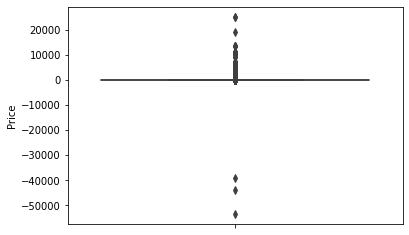

In [21]:
# boxplot of the price

sns.boxplot(y = df['Price'])

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1218: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:ylabel='Quantity'>

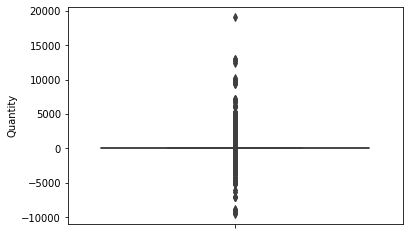

In [23]:
# boxplot of quantity

sns.boxplot(y = df['Quantity'])

#### 3.5. Explore Country column <a id="subpar36"></a>

In [24]:
# Check how many different countries exist in the data

df['Country'].nunique()

41

In [25]:
# check the different countries

df['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', nan, 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'U.K.'], dtype=object)

There are na values and Unspecified in Country column.
All null values will be replaced by "Unspecified"

### 4. Assumptions <a id="par4"></a>

Based on the exploration of the previous paragraph:
<ul>
    <li>Customer ID has the most null values. The columns Description, Country and Price also contain null values</li>
    <li>Most Invoices are numeric. There are also same Invoices that starts with 'c' (cancelations) and 'a' (adjustments).</li>
    <li>There are some stock codes that are related to postage, bank charges etc. and not with products.</li>
    <li>Quantity and prices contain negative values. There are also some outliers that need to be handled.</li>
</ul>

#### 4.1. Assumption 1: Invoices with id's that starts with 'c' should have negative quantities <a id="subpar41"></a>

Invoices that starts with 'c' seems to be cancelations and should have negative quantities.</br>
Cancelation invoices which contain quantities greater or equal to 0 need to be dropped.

In [26]:
# check if all invoices which starts with 'C' have negative quantities 

def check_cancelations(df: pd.DataFrame) -> bool:
    ''' 
    Checks if all cancelations invoices contains negative quantities.
    
    
    Parameters
    ----------
    df: pd.DataFrame
        The pandas dataframe that we want to check if it's cancelations invoices
        contains only negative quantities

    Returns
    -------
    boolean: True if all cancelation invoice contains negative quantities.
             Elswise returns False
    
    '''
    try:
        # check if all cancelation invoices have negative quantities
        return np.all(df[df['Invoice'].astype(str).str.startswith('C')]['Quantity'].lt(0))
    except TypeError:
        print(f"Wrong argument type: You provided {type(df)}, but only pd.DataFrame is allowed")
        return

cancel_neg = check_cancelations(df)

print(cancel_neg)

False


As we observe there are some cancelation invoices that have positive quantities.</br>
Indeed in the code snippet below we can verify that there is one invoice which doesn't follow the previous assumptions. </br>
We are going to drop these kind of invoices.

In [27]:
df[df['Invoice'].astype(str).str.startswith('C') \
                          & df['Quantity'].ge(0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom


In [28]:
def drop_positive_cancelations(df: pd.DataFrame) -> None:
    '''
    Drop cancelations invoices which contains positive quantities.
    
    Parameters
    ----------
    df: pd.DataFrame
        The pandas dataframe that we want to check if it's cancelations invoices
        contains only negative quantities

    Returns
    -------
    None: s
    
    '''
    df.drop(df[df['Invoice'].astype(str).str.contains('C') \
                            & df['Quantity'].ge(0)
              ] \
              .index,
              inplace=True
            )
    

if cancel_neg == False:
    print('Dropping positive cancelations')
    drop_positive_cancelations(df)
else:
    print("All cancelations invoices contains positive quantities")

Dropping positive cancelations


In [29]:
# check id all cancelation invoices contains negative quantities

np.all(df[df['Invoice'].astype(str).str.startswith('C')]['Quantity'].lt(0))

True

#### 4.2. Assumption 2: Negative quantities are only allowed on cancelation invoices<a id="subpar42"/>

In [30]:
# check if all negative quantities are associated with cancelations

def check_neg_quants(df: pd.DataFrame) -> bool:
    ''' 
    Checks if all negative quantities are associated with cancelation invoices.
    
    
    Parameters
    ----------
    df: pd.DataFrame
        The pandas dataframe that we want to check if it's negative quantities
        are only associated with cancelation invoices.

    Returns
    -------
    boolean: True if all negative quantities are associated with cancelation invoices.
             Elswise returns False.
    
    '''
    try:
        # check if all negative quantities are associated with cancelations invoices
        return np.all((df['Quantity'].lt(0)) & (~df['Invoice'].astype(str).str.startswith("C")))
    
    except TypeError:
        print(f"Wrong argument type: You provided {type(df)}, but only pd.DataFrame is allowed")
        return

neg_quants_no_cancel = check_neg_quants(df)

print(neg_quants_no_cancel)

False


As we observe we have negative quantities that are not associated with cancelation invoices.</br>
Indeed, as we can see in the code snippet below, there are 2121 rows which our rule for negative prices.</br>
Based on our assumptions these data are erroneous and should be dropped.

In [31]:
df[df['Quantity'].lt(0) & (~df['Invoice'].astype(str).str.startswith("C"))]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524458,538092,37467,NaN,-177,2010-12-09 14:49:00,0.0,NaN,United Kingdom
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.0,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.0,NaN,United Kingdom


In [32]:
def drop_negative_no_cancelations(df: pd.DataFrame) -> None:
    '''
    Drop cancelations invoices which contains positive quantities.
    
    Parameters
    ----------
    df: pd.DataFrame
        The pandas dataframe that we want to check if it's cancelations invoices
        contains only negative quantities

    Returns
    -------
    None: s
    
    '''
    df.drop(df[df['Quantity'].lt(0) \
               & (~df['Invoice'].astype(str).str.startswith("C"))] \
                .index,
                inplace=True
            )
    

if neg_quants_no_cancel == False:
    drop_negative_no_cancelations(df)
else:
    print("All cancelations invoices contains positive quantities")

As we can see from the following code snippet, </br>
the data that violates the rule for negative quantities have been droped.

In [33]:
df[df['Quantity'].lt(0) & (~df['Invoice'].astype(str).str.startswith("C"))]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


#### 4.3. Assumption 3: Duplicated data are not allowed<a id="subpar43"/>

In [34]:
# check duplicated values
def has_dups(df: pd.DataFrame) -> bool:
    '''
    Check if the dataframe has duplicated values

    Parameters
    ----------
    df: pd.DataFrame
        The pandas dataframe that we want to check if contains duplicated values.

    Returns
    -------
    boolean: True if it contains duplicated values.
             Elsewise returns False. 
    '''
    
    return df.duplicated().sum() > 0

print(has_dups(df))

True


Our data have some duplicated values that needs to be dropped.</br>
We will only keep the first value and the other duplicated rows should be dropped.

In [35]:
# keep only the first row and delete the duplicates (if exist)

if has_dups(df):
    print("Dropping duplicates")
    df.drop_duplicates(keep='first', inplace=True)
else:
    print("Dataset does not contain duplicates")

Dropping duplicates


Duplicated values have been dropped as we can confirm from the following coding snippet/

In [36]:
df[df.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


After the previous cleansing lets check again some basic information about the data.

In [69]:
df.isnull().sum().sort_values(ascending=False)

Customer ID    105704
Description      1101
Country            31
Price              22
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
dtype: int64

#### 4.4. Assumption 4: Description should not be N/A. The valid description of a stock code is the most recent one.
<a id="subpar44"/>

In [37]:
# create a new df that contains only Stock Code and Description

stock_descr = df[['StockCode', 'Description']]

stock_descr

,StockCode,Description
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,79323P,PINK CHERRY LIGHTS
2,79323W,WHITE CHERRY LIGHTS
3,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,21232,STRAWBERRY CERAMIC TRINKET BOX
...,...,...
525456,22271,FELTCRAFT DOLL ROSIE
525457,22750,FELTCRAFT PRINCESS LOLA DOLL
525458,22751,FELTCRAFT PRINCESS OLIVIA DOLL
525459,20970,PINK FLORAL FELTCRAFT SHOULDER BAG


In [38]:
# check if there are null descriptions

stock_descr['Description'].isnull().sum()

1101

In [39]:
# drop null values

stock_descr = stock_descr.dropna()

In [40]:
# check if there are stock codes with more than one descriptions

stock_descr.groupby('StockCode')['Description'].unique().loc[stock_descr.groupby('StockCode')['Description'].unique().apply(lambda x: len(x) > 1)]

StockCode
15058B          [PINK WHITE SPOTS GARDEN PARASOL, PINK POLKADO...
16011                         [ ANIMAL STICKERS, ANIMAL STICKERS]
16012           [FOOD/DRINK SPUNGE STICKERS, FOOD/DRINK SPONGE...
16151A               [FLOWER DES BLUE HANDBAG/ORANG HANDL, found]
16161U             [WRAP,SUKI AND FRIENDS, WRAP SUKI AND FRIENDS]
                                      ...                        
90208           [PAIR OF ENAMEL FLOWER CLUSTER SLIDE, PAIR OF ...
ADJUST          [Adjustment by john on 26/01/2010 16, Adjustme...
BANK CHARGES                        [ Bank Charges, Bank Charges]
DCGSSBOY                                 [update, BOYS PARTY BAG]
DCGSSGIRL                               [update, GIRLS PARTY BAG]
Name: Description, Length: 481, dtype: object

We will keep only the most recently description.

In [41]:
stock_descr.drop_duplicates(subset=['StockCode'], keep='last', inplace=True)

<ipython-input-41-0c67f8ebacd9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_descr.drop_duplicates(subset=['StockCode'], keep='last', inplace=True)


In [42]:
# check if there are stock codes with more than one descriptions

stock_descr.groupby('StockCode')['Description'].unique().loc[stock_descr.groupby('StockCode')['Description'].unique().apply(lambda x: len(x) > 1)]

Series([], Name: Description, dtype: object)

In [43]:
stock_descr['Description'].isnull().sum()

0

Now we have one to one relationships between stock code and description.</br>
Also all the null descriptions have been droped.

#### 4.5. Assumption 5: Quantities should not be 0 <a id="subpar45"></a>

As we have mentioned, quantites are allowed to be negative only in invoices that starts with 'c'. </br>
But they are not allowed to be 0.

In [44]:
# dropping rows with quantity = 0

df.drop(df.loc[df['Quantity']==0].index, inplace=True)

#### 4.6. Assumption 6: Prices should not be negative and null <a id="subpar46"></a>

Prices are not allowed to be negative. </br>
Based on the exploration of the data we observe that there are some prices that are equal to 0.</br>
We assume that these are valid values. Maybe they indicates some gifts given from the stock to loyal users.

In [45]:
df[(df['Price']==0) & ~df['Customer ID'].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.0,15070,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.0,18071,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.0,14258,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.0,12417,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.0,16858,United Kingdom


In [46]:
df[df['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
176269,506141,21826,EIGHT PIECE DINOSAUR SET,1,2010-04-27 16:16:00,-100.00,TEST,United Kingdom
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [47]:
df[df['Price'].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
481260,534470,22338,STAR DECORATION PAINTED ZINC,5,2010-11-23 10:22:00,NaN,18006,United Kingdom
481261,534470,22337,ANGEL DECORATION PAINTED ZINC,5,2010-11-23 10:22:00,NaN,18006,United Kingdom
481262,534470,22339,CHRISTMAS TREE PAINTED ZINC,5,2010-11-23 10:22:00,NaN,18006,United Kingdom
481263,534470,22336,DOVE DECORATION PAINTED ZINC,5,2010-11-23 10:22:00,NaN,18006,United Kingdom
481264,534470,22335,HEART DECORATION PAINTED ZINC,5,2010-11-23 10:22:00,NaN,18006,United Kingdom
481265,534470,22642,SET OF 4 NAPKIN CHARMS STARS,1,2010-11-23 10:22:00,NaN,18006,United Kingdom
481266,534470,22735,RIBBON REEL SOCKS AND MITTENS,2,2010-11-23 10:22:00,NaN,18006,United Kingdom
481267,534470,21730,GLASS STAR FROSTED T-LIGHT HOLDER,1,2010-11-23 10:22:00,NaN,18006,United Kingdom
481268,534470,85053,FRENCH ENAMEL CANDLEHOLDER,1,2010-11-23 10:22:00,NaN,18006,United Kingdom
481269,534470,22844,VINTAGE CREAM DOG FOOD CONTAINER,1,2010-11-23 10:22:00,NaN,18006,United Kingdom


#### 4.7. Assumption 7: Customer ID should be an integer or starts with "G" <a id="subpar47"></a>

As we have mentioned there are some null values for Customer ID column.</br>
These customers are treated as unregistered customers.</br>
For all the unregistered customers we use a code of the format Gxxxx.

In [105]:
df[df['Customer ID'].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [48]:
df[df['Customer ID'].astype(str).str.contains('TEST', flags=re.IGNORECASE)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
176263,506141,21670,BLUE SPOT CERAMIC DRAWER KNOB,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176264,506141,79160,HEART SHAPE WIRELESS DOORBELL,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176265,506141,90112,PINK DOLLY HAIR CLIPS,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176266,506141,90100,NECKLACE+BRACELET SET PINK DAISY,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176267,506141,85226A,WHITE/BLUE PULL BACK RACING CAR,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176268,506141,21890,S/6 WOODEN SKITTLES IN COTTON BAG,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176269,506141,21826,EIGHT PIECE DINOSAUR SET,1,2010-04-27 16:16:00,-100.0,TEST,United Kingdom


In [49]:
# replace na values with Gxxxx

def replace_null_custid(df):
    invoice_customer_mapping = {}
    unique_customer_id = 1
    
    # Iterate through the DataFrame
    for index, row in df.iterrows():
        invoice_id = row['Invoice']
        customer_id = row['Customer ID']
        
        # Check if customer_id is null
        if pd.isnull(customer_id):
            # Generate a new customer ID or use an existing one for the same invoice
            if invoice_id in invoice_customer_mapping:
                new_customer_id = invoice_customer_mapping[invoice_id]
            else:
                new_customer_id = f'G{unique_customer_id:04d}'  # Format as G0001, G0002, etc.
                unique_customer_id += 1
            
            # Replace the null customer ID with the generated/assigned one
            df.at[index, 'Customer ID'] = new_customer_id
            
            # Update the mapping
            invoice_customer_mapping[invoice_id] = new_customer_id
    
    return df

df = replace_null_custid(df)

In [50]:
df[df['Customer ID'].str.contains(r'[A-Z]', flags=re.IGNORECASE) & ~df['Customer ID'].str.startswith('G')]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
176263,506141,21670,BLUE SPOT CERAMIC DRAWER KNOB,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176264,506141,79160,HEART SHAPE WIRELESS DOORBELL,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176265,506141,90112,PINK DOLLY HAIR CLIPS,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176266,506141,90100,NECKLACE+BRACELET SET PINK DAISY,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176267,506141,85226A,WHITE/BLUE PULL BACK RACING CAR,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176268,506141,21890,S/6 WOODEN SKITTLES IN COTTON BAG,1,2010-04-27 16:16:00,0.0,TEST,United Kingdom
176269,506141,21826,EIGHT PIECE DINOSAUR SET,1,2010-04-27 16:16:00,-100.0,TEST,United Kingdom


In [51]:
df[df['Customer ID'].str.startswith('G')]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,G0001,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,G0001,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,G0002,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,G0002,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,G0002,United Kingdom
...,...,...,...,...,...,...,...,...
525144,538154,84029E,RED WOOLLY HOTTIE WHITE HEART.,5,2010-12-09 16:35:00,8.47,G3105,United Kingdom
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2010-12-09 16:35:00,8.47,G3105,United Kingdom
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,G3105,United Kingdom
525147,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,G3105,United Kingdom


All the customers with alphbetic id was deleted.

#### 4.8. Assumption 8: Each Invoice should only contain one Customer ID <a id="subpar48"></a>

In [116]:
# check if every invoice contain only one customer
df.groupby('Invoice')['Customer ID'].unique().loc[df.groupby('Invoice')['Customer ID'].unique().apply(lambda x: len(x) > 1)]

Series([], Name: Customer ID, dtype: object)